### Notebook Settings

In [1]:
from torch.nn import functional as F

# Define a split between training and validation data (since we were not provided with a separate validation dataset.)
# This split helps us calculate validation loss while experimenting with different trainign techniques. However, our final
# submission should be trained on all samples from the data we are given!
VAL_SPLIT = 25000

# Batch size is used to partition the training data into distinct batches which are used to train the CNN.
# Batch creation is facilitated by pytorch's DataLoader module :)
BATCH_SIZE = 64

# The number of epochs used to train the CNN.
EPOCHS = 10

# The loss function used during training
LOSS_FN = F.cross_entropy

# The learning rate used in the SGD that trains the CNN.
SGD_LEARNING_RATE = 0.1

# The momentum used in the SGD that trains the CNN.
SGD_MOMENTUM = 0.9

### Load Labeled Data

In [2]:
import Data # Project data is loaded here
from torch.utils.data import DataLoader, TensorDataset # PyTorch DataLoader and TensorDatasets ;;;)
import torch
import numpy as np

# Partition labeled data into train and val datasets
X_tmp = Data.labeled_images.reshape(-1, 3136)
y_tmp = Data.labels_as_unique_integers() # Binary to number/letter, then number/letter to unique integer represntation for each label (conv net is only happy with 1D numerical outputs)
X_val, y_val = X_tmp[VAL_SPLIT:], y_tmp[VAL_SPLIT:]
X_train, y_train = X_tmp[0:VAL_SPLIT], y_tmp[0:VAL_SPLIT]
print(f'X_train: {X_train.shape} \ny_train: {y_train.shape}')
print(f'X_val: {X_val.shape} \ny_val: {y_val.shape}')

# Transform the labeled train and val datasets into pytorch Tensors
X_train, y_train, X_val, y_val = map(
    torch.tensor, (X_train, y_train, X_val, y_val)
)

print(f'X_train tensor: {X_train} \ny_train tensor: {y_train}')

# Initialize pytorch TensorDatasets
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# Initialize pytorch DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # Shuffled to prevent correlation betwen batch ordering and model overfitting, see: https://pytorch.org/tutorials/beginner/nn_tutorial.html#add-validation
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

X_train: (25000, 3136) 
y_train: (25000,)
X_val: (5000, 3136) 
y_val: (5000,)
X_train tensor: tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 255.,   0.,  ...,   0.,   0.,   0.]], dtype=torch.float64) 
y_train tensor: tensor([904, 516, 808,  ..., 515, 205, 124], dtype=torch.int32)


### Plot Sample Images

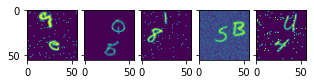

In [3]:
import Plotting
Plotting.plot_images(Data.labeled_images, range(0, 5))

### Train CNN

In [5]:
from torch import optim, nn
from Models import fit, Lambda

def preprocess_input(data):
    print(f'Data shape: {data.shape}, and data sample: {data}.')
    data = data.view(-1, 1, 56, 56).double()
    print(f'Data shape: {data.shape}, and data sample: {data}.')
    return data

model = nn.Sequential(
    Lambda(preprocess_input),
    nn.Conv2d(1, 28, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(28, 28, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(28, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda X : X.view(X.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=SGD_LEARNING_RATE, momentum=SGD_MOMENTUM)
fit(EPOCHS, model, LOSS_FN, opt, train_dl, val_dl)

Data shape: torch.Size([64, 3136]), and data sample: tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  3.2892, -47.1233,  24.1645,  ..., -15.4905,   2.6247,   5.9325],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       dtype=torch.float64).
Data shape: torch.Size([64, 1, 56, 56]), and data sample: tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.00

RuntimeError: expected scalar type Double but found Float